First Step on Deep Learning Using Tensorflow
=============


各位同学们，我们在第九课上已经给大家介绍过了基础的深度学习知识。 这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作 fully-connected（全连接） 网络。 

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。 

本次作业，你需要完成1, 2, 3三个练习。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

等非常重要的知识 

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

### 下载以及解压数据

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """
  A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)
  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
    last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  """
  一般在函数体外定义的变量成为全局变量，在函数内部定义的变量称为局部变量。
  全局变量所有作用域都可用，局部变量只能在本函数可用，变量的使用顺序是，局部变量 > 全局变量, 也就是说：优先使用局部变量
  函数优先使用局部变量，在没有局部变量的情况下会使用全局变量。这里就是使用的全局变量 data_root
  函数内赋值并不能改变全局变量的值，所以需要global关键字
  """
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    """
    urlopen() 可以轻松获取远端 html 页面信息，然后通过 python 正则对所需要的数据进行分析，匹配出想要用的数据；
    再利用urlretrieve() 将数据下载到本地。对于访问受限或者对连接数有限制的远程 url 地址可以采用 proxies（代理的方式）连接，
    如果远程数据量过大，单线程下载太慢的话可以采用多线程下载，此过程为爬虫。
    参数 reporthook 是一个回调函数，当连接上服务器、以及相应的数据块传输完毕时会触发该回调，我们可以利用这个回调函数来显示当前的下载进度。
    """
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  # 使用os.stat获取文件的信息，其中包括文件的大小
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    # raise 语句允许程序员强制发生指定的异常
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [7]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    """
    可以使用如下代码测试 sys.stdout.flush() 的作用

    import time
    import sys

    for i in range(5):
        print(i, end = '')
        sys.stdout.flush()
        time.sleep(1)
    """
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [165]:
print(train_folders)
print(test_folders)

['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [48]:
from IPython.display import Image, display
Image(filename='/Users/cailingling/Documents/AI/nlp-lesson9/notMNIST_large/D/a2F6b28udHRm.png') 

def plot_images(path, n_sample):
    for dir in os.listdir(path):
        print(dir)
        path_image = os.path.join(path, dir)
        image_files = random.sample(os.listdir(path_image), n_sample)
        for image in image_files:
            image_file = path_image + '/' + image
            display(Image(filename=image_file))
            

plot_images('/Users/cailingling/Documents/AI/nlp-lesson9/notMNIST_large', 2)

I


G


A


F


H


J


C


D


E


B


In [163]:
# 查看两套数据的图片数目
def count(dir):
    for letter in os.listdir(dir):
        if letter.endswith('pickle'):continue
        print(letter)
        print(len(os.listdir(os.path.join(dir, letter))))

count("./notMNIST_large/")
count("./notMNIST_small/")

I
52912
G
52912
A
52912
F
52912
H
52912
J
52911
C
52912
D
52912
E
52912
B
52912
I
1872
G
1872
A
1873
F
1873
H
1872
J
1872
C
1873
D
1873
E
1873
B
1873


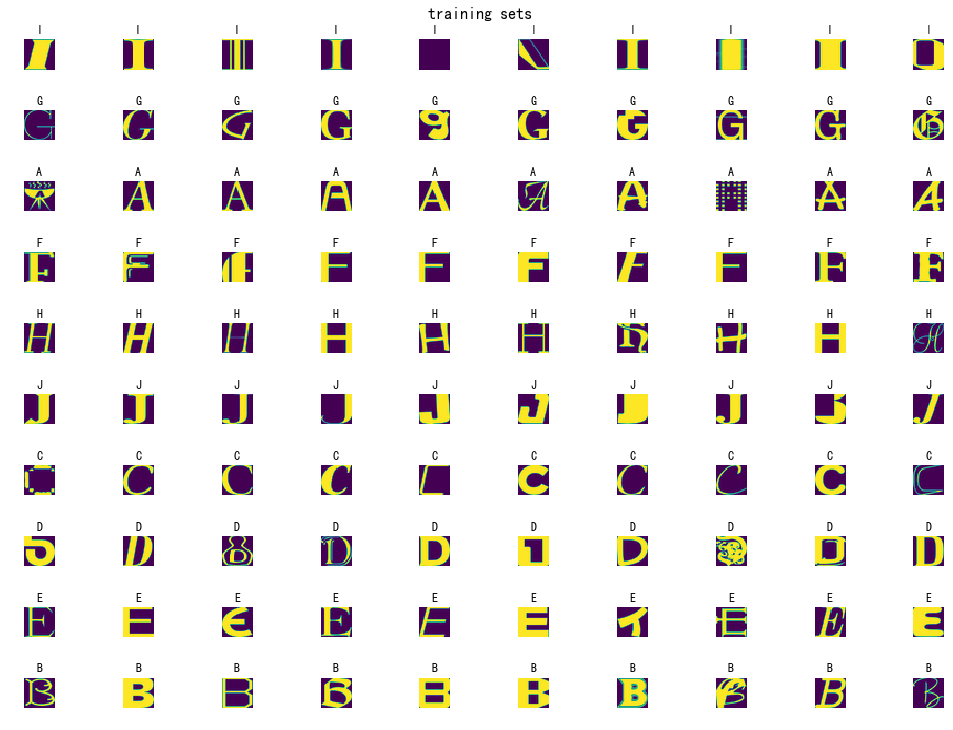

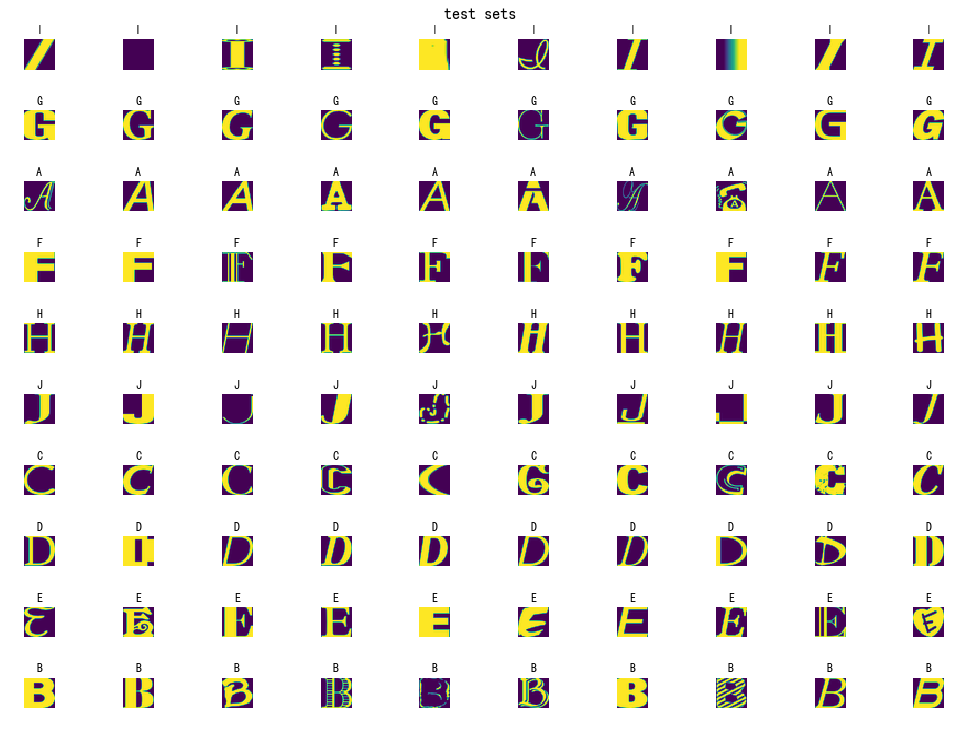

In [16]:
# I refered to https://github.com/Brycexxx/NLP-Assignment/blob/master/Lesson-09/1_notmnist.ipynb
## 参考同学的代码,可视化效果更好 ##
import random
from matplotlib import image

def plot_samples(path, sample_size, title=None):
    fig, axes = plt.subplots(10, sample_size, figsize=(14, 10))
    if title: fig.suptitle(title, y=1.01, fontsize=16, fontweight='bold')
    path = os.path.join('.', path)
    i = 0
    for d in os.listdir(path):
        if d.endswith('.pickle'): continue
        image_path = os.path.join(path, d)
        image_files = random.sample(os.listdir(image_path), sample_size)
        for j, im in enumerate(image_files):
            # 使用 matplotlib包的image读取图片
            im = image.imread(os.path.join(image_path, im))
            axes[i, j].imshow(im)
            axes[i, j].set_title(d)
            axes[i, j].set_axis_off()
        i += 1
    fig.tight_layout()

plot_samples('notMNIST_large', 10, 'training sets')
plot_samples('notMNIST_small', 10, 'test sets')

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [51]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      """
      调用 PIL.Image.open 读取图像的信息。
      PIL.Image.open 不直接返回 numpy.ndarray 对象而是 PIL image 对象，可以用 numpy 提供的函数进行转换
      """
      image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          """
          pickle 是一个 python 中, 压缩/保存/提取 文件的模块. 
          最一般的使用方式非常简单. 比如下面就是压缩并保存一个字典的方式. 字典和列表都是能被保存的.
          pickle.HIGHEST_PROTOCOL这个参数可以将压缩比提高到最大，而且保存速度较快。
          """
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

In [176]:
print(train_datasets)
print(test_datasets)

['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']
['./notMNIST_small/A.pickle', './notMNIST_small/B.pickle', './notMNIST_small/C.pickle', './notMNIST_small/D.pickle', './notMNIST_small/E.pickle', './notMNIST_small/F.pickle', './notMNIST_small/G.pickle', './notMNIST_small/H.pickle', './notMNIST_small/I.pickle', './notMNIST_small/J.pickle']


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [175]:
d = "/Users/cailingling/Documents/AI/nlp-lesson9/notMNIST_large/A.pickle"
d[:-7]
all_images = pickle.load(open(d, 'rb'))
all_images.shape[0]
(d[:-7], all_images.shape[0])
len(list(all_images))

52909

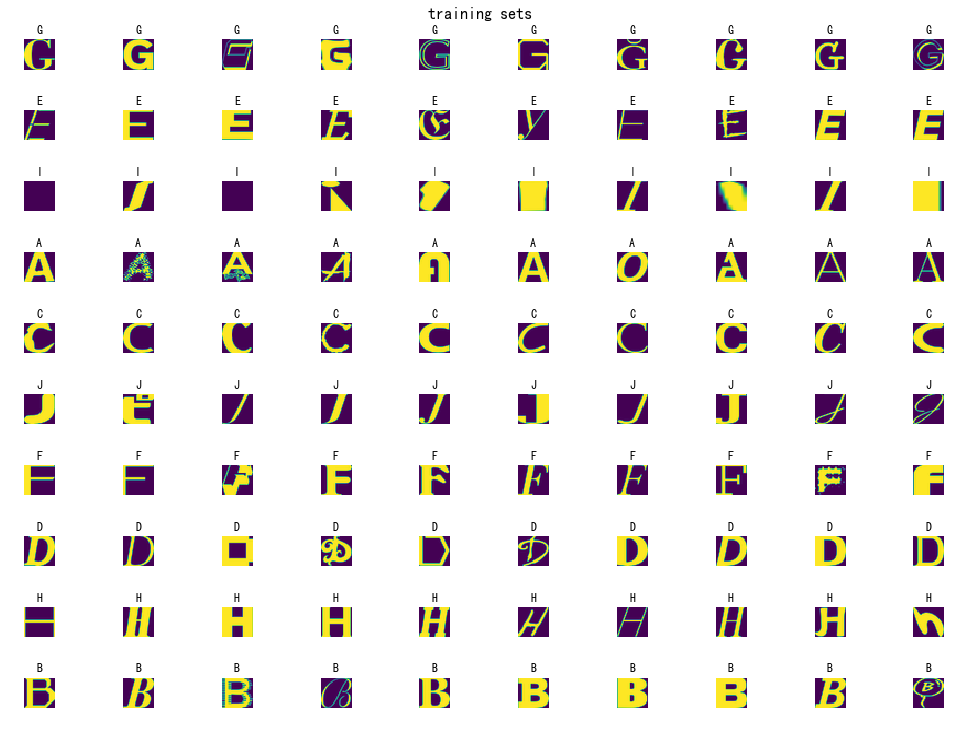

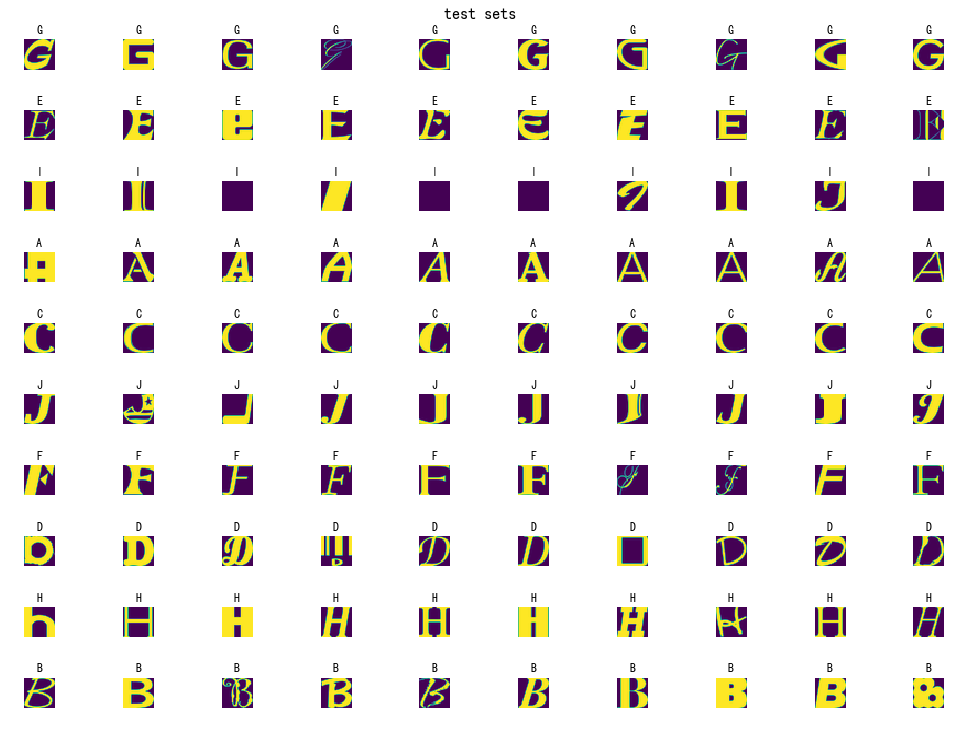

In [52]:
# I refered to https://github.com/Brycexxx/NLP-Assignment/blob/master/Lesson-09/1_notmnist.ipynb
# 只是这里图像是从pickle文件中读取的，而不是使用 imageio.imread 读取的png文件
def plot_samples_from_ndarray(path, sample_size, title=None):
    fig, axes = plt.subplots(10, sample_size, figsize=(14, 10))
    if title: fig.suptitle(title, y=1.01, fontsize=16, fontweight='bold')
    
    path = os.path.join('./', path)
    i = 0
    class_nums = []
    
    for d in os.listdir(path):
        
        if d.endswith('.pickle'):
            image_path = os.path.join(path, d)
            with open(image_path, 'rb') as f:
                all_images = pickle.load(f)
            
            # class_nums用于保存类别以及对应的样本数目
            class_nums.append((d[:-7], all_images.shape[0]))
            # 从 list(all_images) 中随机选取 sample_size 个样本
            image_files = random.sample(list(all_images), sample_size)
            
            for j, im in enumerate(image_files):
                axes[i, j].imshow(im)
                axes[i, j].set_title(d[:-7])
                axes[i, j].set_axis_off()
            i += 1
    
    fig.tight_layout()
    return class_nums

training_class_nums = plot_samples_from_ndarray('notMNIST_large', 10, 'training sets')
test_class_nums = plot_samples_from_ndarray('notMNIST_small', 10, 'test sets')

In [172]:
print(training_class_nums)
print(test_class_nums)

[('G', 52912), ('E', 52912), ('I', 52912), ('A', 52909), ('C', 52912), ('J', 52911), ('F', 52912), ('D', 52911), ('H', 52912), ('B', 52911)]
[('G', 1872), ('E', 1873), ('I', 1872), ('A', 1872), ('C', 1873), ('J', 1872), ('F', 1872), ('D', 1873), ('H', 1872), ('B', 1873)]


---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [62]:
print('---------------- numbers of training sets across classes ----------------')
print(training_class_nums)
print('---------------- numbers of test sets across classes ----------------')
print(test_class_nums)

---------------- numbers of training sets across classes ----------------
[('G', 52912), ('E', 52912), ('I', 52912), ('A', 52909), ('C', 52912), ('J', 52911), ('F', 52912), ('D', 52911), ('H', 52912), ('B', 52911)]
---------------- numbers of test sets across classes ----------------
[('G', 1872), ('E', 1873), ('I', 1872), ('A', 1872), ('C', 1873), ('J', 1872), ('F', 1872), ('D', 1873), ('H', 1872), ('B', 1873)]


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [214]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class + tsize_per_class
  
    # label = 0,1,2,3,4,5,6,7,8,9
  for label, pickle_file in enumerate(pickle_files):       
    
    try: 
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        
        # 看是否需要将数据分两份
        if valid_dataset is not None:
          
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        
        start_t += tsize_per_class
        end_t += tsize_per_class
    
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels

train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [198]:
# test
pickle_files = train_datasets
num_classes = len(pickle_files)
print(num_classes)

# valid_dataset, valid_labels = make_arrays(valid_size, image_size)
# train_dataset, train_labels = make_arrays(train_size, image_size)
# vsize_per_class = valid_size // num_classes
# tsize_per_class = train_size // num_classes

start_v, start_t = 0, 0
end_v, end_t = vsize_per_class, tsize_per_class
end_l = vsize_per_class + tsize_per_class
print(end_v, end_t)
print(end_l)
print(start_v, end_v)
print(start_t, end_t)

for label, pickle_file in enumerate(pickle_files): 
    print(label)
    print(pickle_file)

10
1000 20000
21000
0 1000
0 20000
0
./notMNIST_large/A.pickle
1
./notMNIST_large/B.pickle
2
./notMNIST_large/C.pickle
3
./notMNIST_large/D.pickle
4
./notMNIST_large/E.pickle
5
./notMNIST_large/F.pickle
6
./notMNIST_large/G.pickle
7
./notMNIST_large/H.pickle
8
./notMNIST_large/I.pickle
9
./notMNIST_large/J.pickle


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [54]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [200]:
print(train_labels.shape[0])
print(test_labels.shape[0])
print(valid_labels.shape[0])

200000
10000
10000


---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}


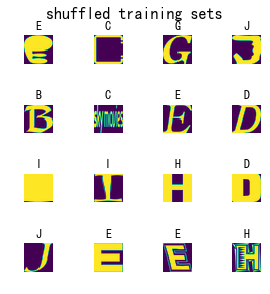

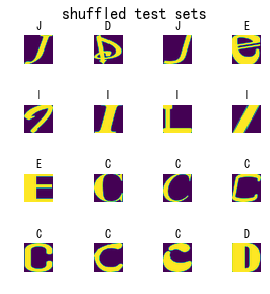

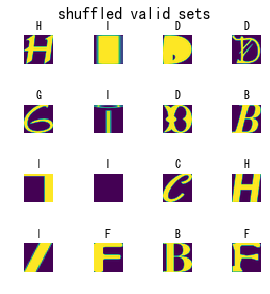

In [221]:
# I refered to https://github.com/Brycexxx/NLP-Assignment/blob/master/Lesson-09/1_notmnist.ipynb
letter_label_map = {i: chr(ord('A')+i) for i in range(10)}
print(letter_label_map)

def plot_shuffled_samples(datasets, labels, title=None):
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    
    if title: fig.suptitle(title, y=1.01, fontsize=16, fontweight='bold')
    
    sample_idx = random.sample(range(datasets.shape[0]),16)
    x_samples = datasets[sample_idx]
    label_samples = labels[sample_idx]
    
    for i, idx in enumerate(sample_idx):
        # 第r行c列的图
        r, c = divmod(i, 4)
        axes[r, c].imshow(datasets[idx])
        axes[r, c].set_title(letter_label_map[labels[idx]])
        axes[r, c].set_axis_off()
    
    fig.tight_layout()

plot_shuffled_samples(train_dataset, train_labels, title='shuffled training sets')
plot_shuffled_samples(test_dataset, test_labels, title='shuffled test sets')
plot_shuffled_samples(valid_dataset, valid_labels, title='shuffled valid sets')

In [226]:
print(train_dataset.shape)
print(test_dataset.shape)
print(valid_dataset.shape[0])

print(divmod(0, 4))
print(divmod(1, 4))
print(divmod(2, 4))
print(divmod(3, 4))
print(divmod(4, 4))
print(divmod(5, 4))
print(divmod(6, 4))
print(divmod(7, 4))
print(divmod(8, 4))
print(divmod(9, 4))
print(divmod(15, 4))
print(divmod(16, 4))

(200000, 28, 28)
(10000, 28, 28)
10000
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(3, 3)
(4, 0)


Finally, let's save the data for later reuse:

In [227]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
print(pickle_file)

# 将train,test,valid数据都保存为pickle文件
try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()

except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

./notMNIST.pickle


In [0]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 718193801


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [314]:
import imagehash
from PIL import Image

"""查找数据集合内部的重复图片,如果训练集内部之间存在重叠，那么就会重复训练模型，导致过拟合"""
def find_duplicates(dataset, label):
    dataset_hash = [str(imagehash.phash(Image.fromarray(img, mode='P'))) for img in dataset]
    overlap_removed = []
    
    for i in list(set(dataset_hash)):
        overlap_removed.append(dataset_hash.index(i))
    
    dataset_removedDup = dataset[overlap_removed, :, :]
    label_removeDup = label[overlap_removed]
    
    return dataset_removedDup, label_removeDup


"""查找两个数据集之间的重叠图片，为了避免 测试集和验证集 与 训练集 之间有重叠，那么也会导致过拟合"""
def find_overlap(dataset_1, dataset_2):
    
    dataset_1_hash = [str(imagehash.phash(Image.fromarray(img, mode='P'))) for img in dataset_1]
    dataset_2_hash = [str(imagehash.phash(Image.fromarray(img, mode='P'))) for img in dataset_2]
    
    a = []
    b = []
    for i, hash in enumerate(dataset_2_hash):
        if hash in dataset_1_hash:
            b.append(i)
            a.append(dataset_1_hash.index(hash))
    
    return a, b

In [317]:
valid_dataset_removedDup, valid_label_removedDup = find_duplicates(valid_dataset, valid_labels)

(9811, 28, 28)


In [320]:
test_dataset_removedDup, test_label_removedDup = find_duplicates(test_dataset, test_labels)

In [323]:
train_dataset_removedDup, train_label_removedDup = find_duplicates(train_dataset, train_labels)

In [324]:
print(valid_dataset.shape)
print(valid_dataset_removedDup.shape)
print(test_dataset.shape)
print(test_dataset_removedDup.shape)
print(train_dataset.shape)
print(train_dataset_removedDup.shape)

(10000, 28, 28)
(9811, 28, 28)
(10000, 28, 28)
(9600, 28, 28)
(200000, 28, 28)
(181686, 28, 28)


In [325]:
# 获得训练集和测试集之间的重叠，overlap_1为重叠的图片在train_dataset中的index,overlap_2为重叠的图片在test_dataset中的index。
overlap_1, overlap_2 = find_overlap(train_dataset_removedDup, test_dataset_removedDup)
overlap_3, overlap_4 = find_overlap(train_dataset_removedDup, valid_dataset_removedDup)

In [326]:
print(len(overlap_1))
print(len(overlap_2))
print(len(overlap_3))
print(len(overlap_4))

1353
1353
1329
1329


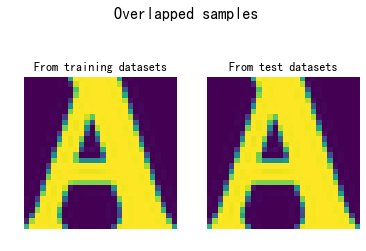

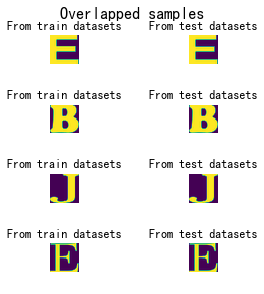

In [333]:
def plot_overlap_multiple(overlap_1, overlap_2):
    index = random.sample(range(len(overlap_1)), 4)
    
    fig, axes = plt.subplots(4, 2, figsize=(4, 4))
    fig.suptitle('Overlapped samples', y=1.01, fontsize=16, fontweight='bold')
    
    for i, j in enumerate(index):
        train_overlap = overlap_1[j]
        test_overlap = overlap_2[j]

        axes[i, 0].imshow(train_dataset_removedDup[train_overlap])
        axes[i, 0].set_title('From train datasets')
        axes[i, 0].set_axis_off()

        axes[i, 1].imshow(test_dataset_removedDup[test_overlap])
        axes[i, 1].set_title('From test datasets')
        axes[i, 1].set_axis_off()
        fig.tight_layout()

def plot_overlap_single(overlap_1, overlap_2):
    
    index = random.sample(range(len(overlap_1)), 1)
    train_overlap = overlap_1[index[0]]
    test_overlap = overlap_2[index[0]]
    
    fig, (ax1, ax2) =  plt.subplots(1, 2)
    fig.suptitle('Overlapped samples', y=1.01, fontsize=16, fontweight='bold')
    
    ax1.imshow(train_dataset_removedDup[train_overlap])
    ax1.set_title('From training datasets')
    ax1.set_axis_off()
    
    ax2.imshow(test_dataset_removedDup[test_overlap])
    ax2.set_title('From test datasets')
    ax2.set_axis_off()

    
plot_overlap_single(overlap_1, overlap_2)
plot_overlap_multiple(overlap_1, overlap_2)

In [327]:
# 从测试集中移除和训练集重叠的图片
test_dataset_sanitized, test_label_sanitized = np.delete(test_dataset_removedDup, overlap_2, 0), np.delete(test_label_removedDup, overlap_2)

# 从验证集中移除和训练集重叠的图片
valid_dataset_sanitized, valid_label_sanitized = np.delete(valid_dataset_removedDup, overlap_4, 0), np.delete(valid_label_removedDup, overlap_4)


In [341]:
print(train_label_removedDup.shape)
print(test_label_sanitized.shape)
print(valid_label_sanitized.shape)

print(train_dataset_removedDup.shape)
print(test_dataset_sanitized.shape)
print(valid_dataset_sanitized.shape)

(181686,)
(8247,)
(8482,)
(181686, 28, 28)
(8247, 28, 28)
(8482, 28, 28)


In [358]:
pickle_file = os.path.join(data_root, 'notMNIST_sanitized.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset_removedDup,
        'train_labels': train_label_removedDup,
        'valid_dataset': valid_dataset_sanitized,
        'valid_labels': valid_label_sanitized,
        'test_dataset': test_dataset_sanitized,
        'test_labels': test_label_sanitized,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [359]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 623023606


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [342]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

lr = LogisticRegression(n_jobs=4)
n_samples = train_dataset_removedDup.shape[0]

In [357]:
sample_size = 50
sample_idx = random.sample(range(n_samples), sample_size)

print(train_dataset_removedDup[sample_idx].shape)
print(train_dataset_removedDup[sample_idx].reshape(sample_size, -1).shape)

x_train, y_train = train_dataset_removedDup[sample_idx].reshape(sample_size, -1), train_label_removedDup[sample_idx]

lr.fit(x_train, y_train)
lr.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)

(50, 28, 28)
(50, 784)


0.5475

In [350]:
sample_size = 100
sample_idx = random.sample(range(n_samples), sample_size)

x_train, y_train = train_dataset_removedDup[sample_idx].reshape(sample_size, -1), train_label_removedDup[sample_idx]

lr.fit(x_train, y_train)
lr.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)

0.6525

In [351]:
sample_size = 1000
sample_idx = random.sample(range(n_samples), sample_size)

x_train, y_train = train_dataset_removedDup[sample_idx].reshape(sample_size, -1), train_label_removedDup[sample_idx]

lr.fit(x_train, y_train)
lr.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)

0.7483

In [352]:
sample_size = 5000
sample_idx = random.sample(range(n_samples), sample_size)

x_train, y_train = train_dataset_removedDup[sample_idx].reshape(sample_size, -1), train_label_removedDup[sample_idx]

lr.fit(x_train, y_train)
lr.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)

0.7816